<h1>Caso Practico - Aprendizaje Automático</h1>

* Wagner Salazar
* Stefy Franco
* Gustavo Larriva
* Angel

In [225]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
# sns.set(style="whitegrid")

# Carga

In [184]:
df_data = pd.read_csv("./online_shoppers_intention.csv")
print(f"Se cargo correctamente un DataFrame con {df_data.shape[0]} registros y {df_data.shape[1]} columnas")

Se cargo correctamente un DataFrame con 12330 registros y 18 columnas


# Exploración

## Nulos

In [185]:
print(df_data.isna().sum())
print("\n")
print("Por instrucción del caso se deben eliminar los valores nulos del dataset.")
df_data.dropna(inplace=True)

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64


Por instrucción del caso se deben eliminar los valores nulos del dataset.


## Revisión variables categóricas

Se parte la exploración de los datos desde las variables categóricas ya que es más sencillo verificar su coherencia

In [186]:
categorical_col = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Revenue"]
for col in df_data[categorical_col].columns:
    print(f"{col}")
    print(f"Categorías: {df_data[col].unique()}")
    print("------------------")

Month
Categorías: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
------------------
OperatingSystems
Categorías: [1 2 4 3 7 6 8 5]
------------------
Browser
Categorías: [ 1  2  3  4  5  6  7 10  8  9 12 13 11]
------------------
Region
Categorías: [1 9 2 3 4 5 6 7 8]
------------------
TrafficType
Categorías: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]
------------------
VisitorType
Categorías: ['Returning_Visitor' 'New_Visitor' 'Other']
------------------
Weekend
Categorías: [False  True]
------------------
Revenue
Categorías: [False  True]
------------------


### Months
* Estandarizar junio June => Jun
* Es necesario establecer un órden para la categoría
* Convertir en categorical

In [187]:
df_data["Month"] = np.where(df_data["Month"] == "June", "Jun", df_data["Month"])
months = ['Feb', 'Mar', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_data["Month"] = pd.Categorical(df_data["Month"], categories=months, ordered=True)

No es necesario revisar el resto de variables categóricas. Ya que no tienen valores nulos y sus clasificaciones corresponde al tipo de varible explicada. A continuación se convierten las variables categóricas en categorical con un orden lógico para las variables con enteros, los object .

In [188]:
for col in categorical_col[1:]:
    # print(df_data[col].dtype)
    if (df_data[col].dtype == "int64"):
        min = df_data[col].min()
        max = df_data[col].max()
        order = np.arange(min, max+1)
        df_data[col] = pd.Categorical(df_data[col], categories=order, ordered=True)
    elif (df_data[col].dtype == "object"):
        df_data[col] = pd.Categorical(df_data[col], categories=df_data[col].unique())

In [189]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12316 non-null  float64 
 1   Administrative_Duration  12316 non-null  float64 
 2   Informational            12316 non-null  float64 
 3   Informational_Duration   12316 non-null  float64 
 4   ProductRelated           12316 non-null  float64 
 5   ProductRelated_Duration  12316 non-null  float64 
 6   BounceRates              12316 non-null  float64 
 7   ExitRates                12316 non-null  float64 
 8   PageValues               12316 non-null  float64 
 9   SpecialDay               12316 non-null  float64 
 10  Month                    12316 non-null  category
 11  OperatingSystems         12316 non-null  category
 12  Browser                  12316 non-null  category
 13  Region                   12316 non-null  category
 14  TrafficType

## Información transaccional

El objetivo del análisis exploratorio es determinar que variables guaradan un correlación fuerte con las visitas al aplicativo web que concluyeron en una venta. Se analizan las variables obtenidas desde el sistema transaccional en dos grupos: 
* Interacciones por tipo de página
    * Administrative
    * Informational
    * ProductRelated
* Duración de las interaciones por tipo de página
    * Administrative_Duration
    * Informational_Duration
    * ProductRelated_Duration

Las variables detalladas arriba se clasificaran contra **Revenue**. Ya está determina si el cliente realizó una compra o no.

### Promedio de interacciones por tipo de página

In [190]:
df_temp_1 = df_data.groupby(by=["Revenue"])[["Administrative", "Informational", "ProductRelated"]].mean().reset_index()
df_temp_1["Revenue"] = np.where(df_temp_1["Revenue"]==True, "Comprador", "No Comprador")
df_temp_1 = df_temp_1.melt(id_vars=["Revenue"], value_vars=["Administrative", "Informational", "ProductRelated"], var_name="TipoPagina", value_name="Value")
df_temp_1 = df_temp_1.sort_values(by=["Revenue", "TipoPagina", "Value"])
display(df_temp_1)

,Revenue,TipoPagina,Value
1,Comprador,Administrative,3.393606
3,Comprador,Informational,0.786164
5,Comprador,ProductRelated,48.210168
0,No Comprador,Administrative,2.120580
2,No Comprador,Informational,0.452248
4,No Comprador,ProductRelated,28.748943


### Promedio de duración de las interacciones por tipo de página

In [191]:
df_temp_2 = df_data.groupby(by=["Revenue"])[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].mean().reset_index()
df_temp_2["Revenue"] = np.where(df_temp_2["Revenue"]==True, "Comprador", "No Comprador")
df_temp_2 = df_temp_2.melt(id_vars=["Revenue"], value_vars=["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"], var_name="TipoPagina", value_name="TotalDuration")
df_temp_2 = df_temp_2.sort_values(by=["Revenue", "TipoPagina", "TotalDuration"])
display(df_temp_2)

,Revenue,TipoPagina,TotalDuration
1,Comprador,Administrative_Duration,119.483244
3,Comprador,Informational_Duration,57.611427
5,Comprador,ProductRelated_Duration,1876.209615
0,No Comprador,Administrative_Duration,73.834208
2,No Comprador,Informational_Duration,30.270759
4,No Comprador,ProductRelated_Duration,1071.347468


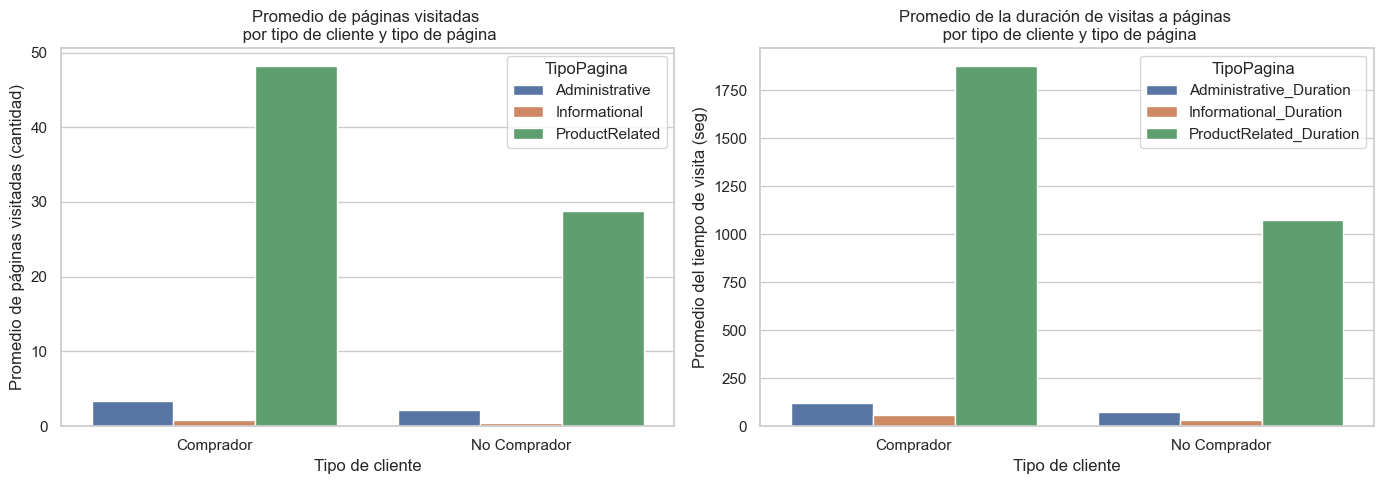

In [192]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x="Revenue", y="Value", hue="TipoPagina", data=df_temp_1, ax=axes[0])
axes[0].set_xlabel("Tipo de cliente")
axes[0].set_ylabel("Promedio de páginas visitadas (cantidad)")
axes[0].set_title("Promedio de páginas visitadas \n por tipo de cliente y tipo de página")
sns.barplot(x="Revenue", y="TotalDuration", hue="TipoPagina", data=df_temp_2, ax=axes[1])
axes[1].set_xlabel("Tipo de cliente")
axes[1].set_ylabel("Promedio del tiempo de visita (seg)")
axes[1].set_title("Promedio de la duración de visitas a páginas \n por tipo de cliente y tipo de página")
plt.tight_layout()
plt.show()

Los gráficos de arriba destacan la importancia de páginas relacionadas al producto (*ProductoRelated*) con los cliente clasificados como compradores. Por una parte los compradores visitan más paginas relacionadas al producto que los no compradores, de igual manera su tiempo de permanencia (duración de la visita) en estas páginas es superior. 

Este comportamiento permite concluir que las páginas relacionadas al producto tiene una influiencia fuerte en las decisiones de compra de los clientes



### Análisis por tipo de visitantes

La data también incluye una clasificación para los tipo de visitantes:
* Returning_Visitor
* New_Visitor
* Other

El objetivo del análisis a continuación es determinar si existe una relación entre las sesiones de cada tipo de visitante y su decisión de compra

,VisitorType,Revenue,SessionCount
0,Returning_Visitor,No Comprador,9067
1,Returning_Visitor,Comprador,1470
2,New_Visitor,No Comprador,1272
3,New_Visitor,Comprador,422
4,Other,No Comprador,69
5,Other,Comprador,16


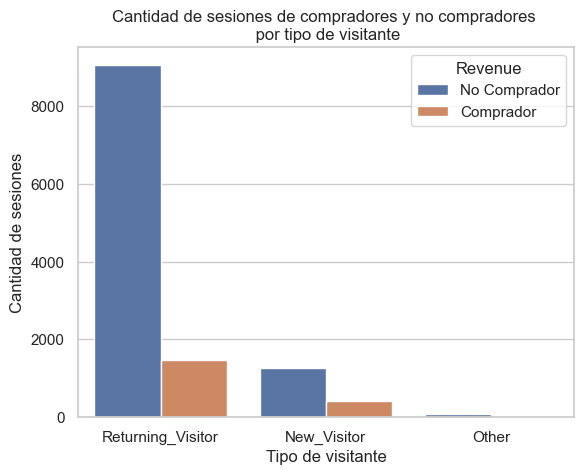

In [193]:
df_temp_3 = df_data.groupby(by=["VisitorType", "Revenue"], observed=False).count()["ProductRelated"].reset_index().rename(columns={"ProductRelated": "SessionCount"})
df_temp_3["Revenue"] = np.where(df_temp_3["Revenue"], "Comprador", "No Comprador")
display(df_temp_3)
sns.barplot(x="VisitorType", y="SessionCount", hue="Revenue", data=df_temp_3)
plt.ylabel("Cantidad de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Cantidad de sesiones de compradores y no compradores \n por tipo de visitante")
plt.show()

A simple vista se podría decir que los visitantes que regresan al sitio (*Returning_Visitor*) realizan más compras, pero para analizar esta información de forma objetiva es necesario manejar los valores a nivel porcentual para cada tipo de visitante y su clasificación de comprador o no comprador

,VisitorType,SessionPercentage_Buyer,SessionPercentage_NonBuyer
0,Returning_Visitor,13.95,86.05
1,New_Visitor,24.91,75.09
2,Other,18.82,81.18


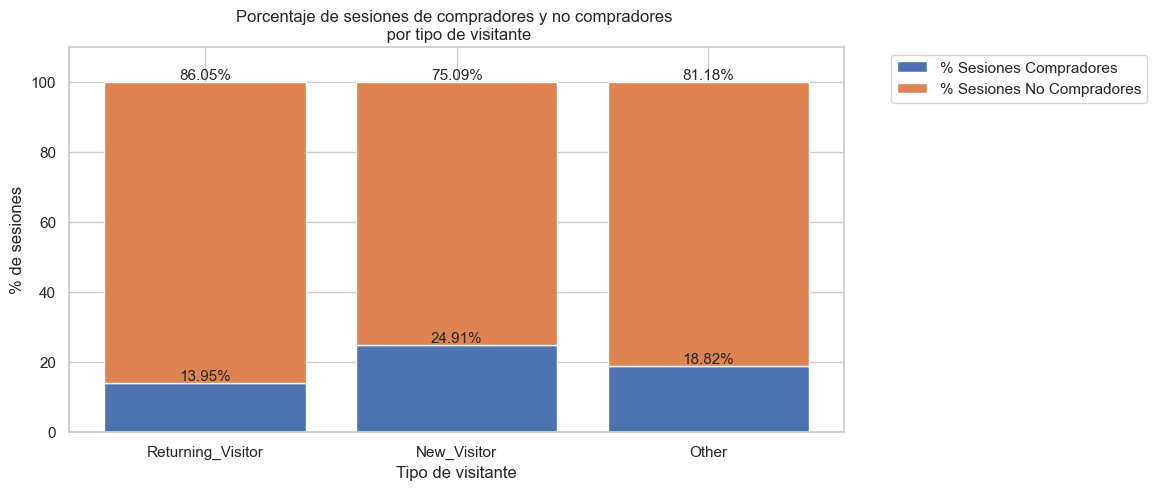

In [194]:
df_temp_4 = pd.DataFrame(df_data.groupby(by=["VisitorType", "Revenue"], observed=False)["ProductRelated"].count().reset_index().rename(columns={"ProductRelated":"SessionCount"}))
df_temp_4["Revenue"] = np.where(df_temp_4["Revenue"], "Comprador", "No Comprador")
df_temp_4.rename(columns={"Revenue": "Tipo de cliente"}, inplace=True)
df_temp_4 = pd.merge(df_temp_4, df_temp_4.groupby(by=["VisitorType"], observed=False).sum(numeric_only=True).reset_index().rename(columns={"SessionCount":"TotalSession"}), on=["VisitorType"], how="left")
df_temp_4["SessionPercentage"] = round((df_temp_4["SessionCount"] / df_temp_4["TotalSession"]) * 100, 2)
df_temp_4 = df_temp_4.pivot(index='VisitorType', columns='Tipo de cliente', values='SessionPercentage').reset_index()
df_temp_4.columns.name = None
df_temp_4.rename(columns={"Comprador":"SessionPercentage_Buyer", "No Comprador": "SessionPercentage_NonBuyer"}, inplace=True)
display(df_temp_4)
plt.figure(figsize=(10,5))

bars1 = plt.bar(df_temp_4["VisitorType"], df_temp_4["SessionPercentage_Buyer"], label="% Sesiones Compradores")
bars2 = plt.bar(df_temp_4["VisitorType"], df_temp_4["SessionPercentage_NonBuyer"], bottom = df_temp_4["SessionPercentage_Buyer"], label="% Sesiones No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_4["SessionPercentage_Buyer"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_4["SessionPercentage_NonBuyer"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Porcentaje de sesiones de compradores y no compradores \n por tipo de visitante")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

A pesar que la cantidad de sesiones de visitantes que retornan al sitio es mayor estos en su mayoría no realizan compras, unicamente un 13.9% del total de Returning_Visitor realizan una compra en la página. Mientras que el 24.9% de nuevos visitantes realizan compras.

Esto permite concluir que la página influye más en la decisión de compra de nuevos visitantes que en la de visitantes antiguos.

### Google Analytics Metrics

Como parte del dataset se incluyen las métricas de *engagement* o compromiso. La intención del análisis a continuación es determinar la relación que mantienen estas métricas con la clasificación de la sesión del cliente como comprador o no comprador.

Se consideran las siguientes variables
* BounceRates
* ExitRates
* PageValues

#### ExitRates vs BounceRates

ExitRates: Por definición es una metrica que muestra el porcentaje de salidas desde una página. En este dataset mostrado en sesiones de usuario es el promedio de la *tasa de salida* de páginas visitadadas en cada sesión registrada

BounceRates: Por definicion es un métrica que muestra el porcentaje de visitantes que salieron del sitio después de visitar solo una página. En este dataset mostrado en sesiones es el promedio de la *tasa de rebote* de las páginas visitada por el usuario durante la sesión

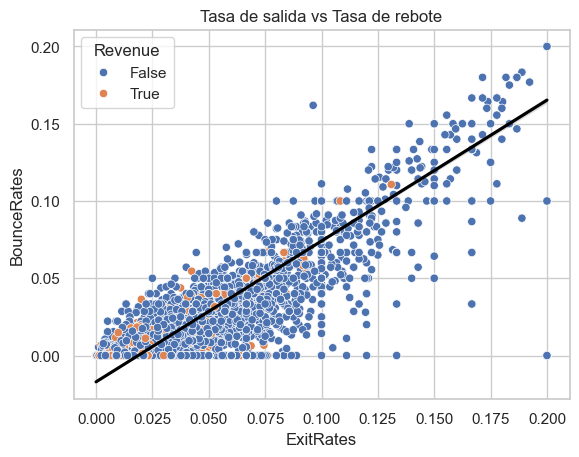

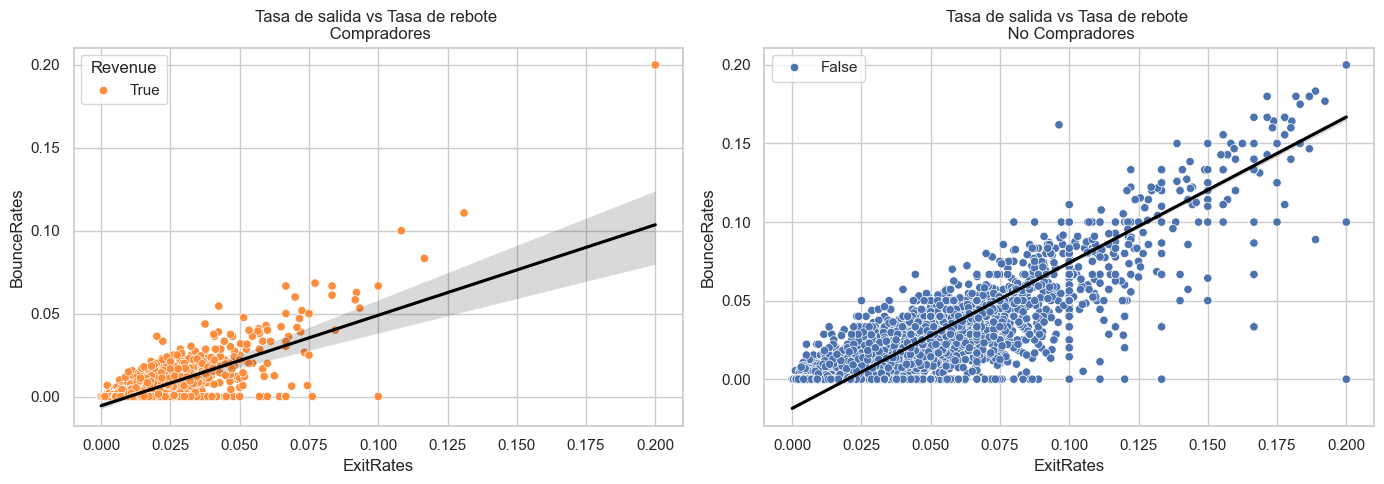

In [195]:
sns.scatterplot(data=df_data, x="ExitRates", y="BounceRates", hue="Revenue")
sns.regplot(data=df_data, x="ExitRates", y="BounceRates", scatter=False, color="Black")
plt.title("Tasa de salida vs Tasa de rebote")


fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(data=df_data[df_data["Revenue"]], x="ExitRates", y="BounceRates", hue="Revenue", ax=axes[0], palette="Oranges")
sns.regplot(data=df_data[df_data["Revenue"]], x="ExitRates", y="BounceRates", scatter=False, color="Black", ax=axes[0])
axes[0].set_title("Tasa de salida vs Tasa de rebote \n Compradores")

sns.scatterplot(data=df_data[~df_data["Revenue"]], x="ExitRates", y="BounceRates", hue="Revenue", ax=axes[1])
sns.regplot(data=df_data[~df_data["Revenue"]], x="ExitRates", y="BounceRates", scatter=False, color="Black", ax=axes[1])
axes[1].set_title("Tasa de salida vs Tasa de rebote \n No Compradores")

plt.legend()
plt.tight_layout()
plt.show()

Los gráficos de puntos muestran una correlación positiva entre *ExitRates* y *BounceRates* es decir, a mayor tasa da salida mayor tasa de rebote. 

Para determinar si estas variables mantienen relación con la influencia de compra se realiza el segundo gráfico separando las sesiones que culminan con una compra y las sesiones que no. A la izquierda en color naranja se muestran las sesiones de clientes que compraron. Este gráfico confirma la correlación positiva de las variables y permite concluir que valores bajos en ambas variables (tasa de salida y rebote) son indicativos de una compra.

#### PageValues

Por definición esta metrica está relacionada con las compras realizadas a través de sitio. Generalmente permite evaluar que tan influyente es una página en las decisiones de compra de un usuario. Considerando que la data está expresada en sesiones este valor es el promedio de los indicadores de cada página visitada por el usuario durante la sesión. 

,count,mean,std,min,25%,50%,75%,max
Revenue,,,,,,,,
False,10408.0,1.978656,9.078234,0.0,0.000000,0.000000,0.000000,246.758590
True,1908.0,27.264518,35.191954,0.0,3.641144,16.758134,38.897742,361.763742


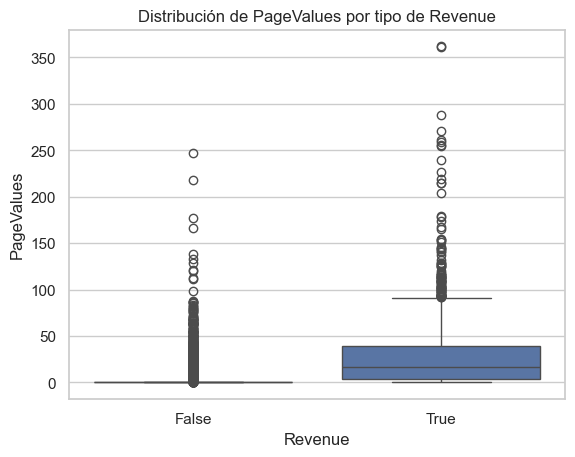

In [196]:
display(df_data.groupby("Revenue").describe()["PageValues"])
sns.boxplot(data=df_data, x="Revenue", y="PageValues")
plt.title("Distribución de PageValues por tipo de Revenue")
plt.show()

El gráfico de arriba indica que las sesiones que concluyeron en una compra efectivamente tiene relación con *PageValues*, pero la información mostrada no es concluyente. Se propone validar si *PageValues* solo es 0 cuando **no** hay compra y mayor que cero cuando hay compra.

In [197]:
rev_pv_my0 = df_data[(df_data["Revenue"]) & (df_data["PageValues"] > 0)].shape[0]
rev_pv_ig0 = df_data[(df_data["Revenue"]) & (df_data["PageValues"] == 0)].shape[0]

notRev_pv_my0 = df_data[(~df_data["Revenue"]) & (df_data["PageValues"] > 0)].shape[0]
notRev_pv_ig0 = df_data[(~df_data["Revenue"]) & (df_data["PageValues"] == 0)].shape[0]

df_temp_5 = pd.DataFrame({
    "Q PageValue > 0": [rev_pv_my0, notRev_pv_my0],
    "Q PageValue = 0": [rev_pv_ig0, notRev_pv_ig0]
}, index=["Compradores", "No Compradores"])

print(f'{rev_pv_my0} registros tienen Revenue y PageValues > 0')
print(f'{rev_pv_ig0} registros tienen Revenue y PageValues = 0')

print(f'{notRev_pv_my0} registros NO tienen Revenue y PageValues > 0')
print(f'{notRev_pv_ig0} registros NO tienen Revenue y PageValues = 0')

display(df_temp_5)

1538 registros tienen Revenue y PageValues > 0
370 registros tienen Revenue y PageValues = 0
1192 registros NO tienen Revenue y PageValues > 0
9216 registros NO tienen Revenue y PageValues = 0


,Q PageValue > 0,Q PageValue = 0
Compradores,1538,370
No Compradores,1192,9216


El dataframe de arriba desvalida la hipótesis de arriba. Existen registros que no terminaron en compra y tiene un PageValue > 0. Tambien existen registros donde se realizaron compras con PageValue igual a 0. 

Con esta nueva información se propone conocer la distribución de compradores y no compradores en función del valor de la PageValue segmentado en las dos categorías

In [198]:
df_temp_6 = df_temp_5.transpose().reset_index().rename(columns={"index":"Cat_PageValue"})
df_temp_6["% Compradores"] = round((df_temp_6["Compradores"] / (df_temp_6["Compradores"] + df_temp_6["No Compradores"]))*100,2)
df_temp_6["% No Compradores"] = round((df_temp_6["No Compradores"] / (df_temp_6["Compradores"] + df_temp_6["No Compradores"]))*100,2)
df_temp_6

,Cat_PageValue,Compradores,No Compradores,% Compradores,% No Compradores
0,Q PageValue > 0,1538,1192,56.34,43.66
1,Q PageValue = 0,370,9216,3.86,96.14


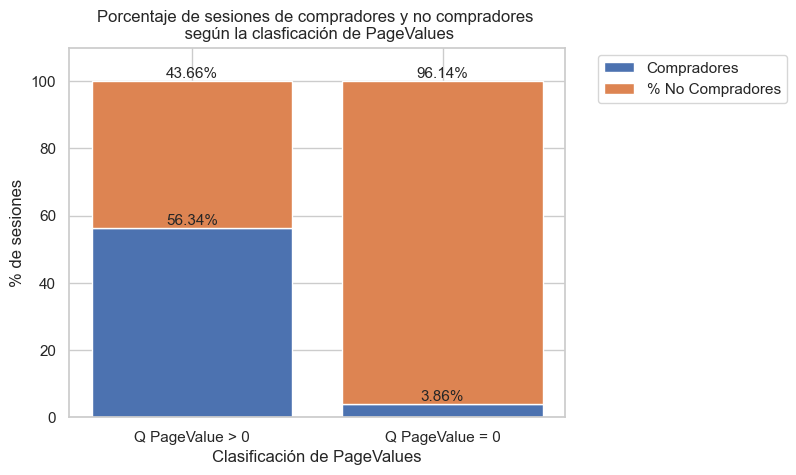

In [199]:
bars1 = plt.bar(df_temp_6["Cat_PageValue"], df_temp_6["% Compradores"], label = "Compradores")
bars2 = plt.bar(df_temp_6["Cat_PageValue"], df_temp_6["% No Compradores"], bottom = df_temp_6["% Compradores"], label="% No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_6["% Compradores"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_6["% No Compradores"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Clasificación de PageValues")
plt.title("Porcentaje de sesiones de compradores y no compradores \n según la clasficación de PageValues")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Mas de la mitad de registros con *PageValues* mayor a 0 están relacionados a una sesión que culminó en compra. Esto es prueba suficiente que existe una correlación fuerte entre las variables *PageValues* y *Revenue*

### Análisis temporal
En la sección a continuación se intenta determinar si las variables temporales:
* Month
* Weekend

Mantiene una correlación con la variable objetivo *Revenue*

#### Month

In [200]:
df_temp_7 = pd.DataFrame(df_data.groupby(by=["Month", "Revenue"])["ProductRelated"].count()).reset_index()
df_temp_7["Revenue"] =np.where(df_temp_7["Revenue"], "Comprador", "No Comprador")
df_temp_7.rename(columns={"ProductRelated":"SessionCount"}, inplace=True)
df_temp_7.head()

C:\Users\desarrollo2\AppData\Local\Temp\ipykernel_36268\4072768265.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp_7 = pd.DataFrame(df_data.groupby(by=["Month", "Revenue"])["ProductRelated"].count()).reset_index()


,Month,Revenue,SessionCount
0,Feb,No Comprador,181
1,Feb,Comprador,3
2,Mar,No Comprador,1702
3,Mar,Comprador,192
4,May,No Comprador,2998


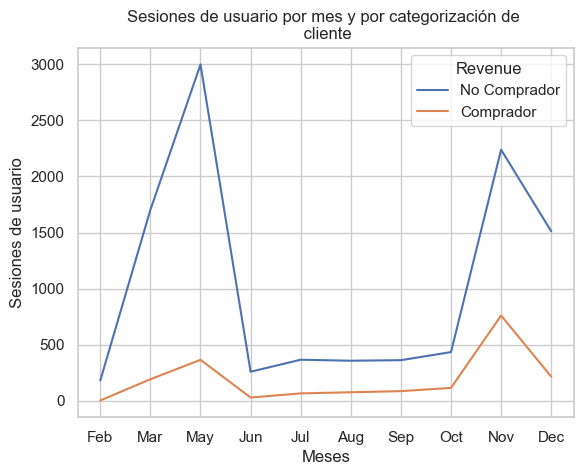

In [201]:
sns.lineplot(data=df_temp_7, x="Month", y="SessionCount", hue="Revenue")
plt.xlabel("Meses")
plt.ylabel("Sesiones de usuario")
plt.title("Sesiones de usuario por mes y por categorización de \n cliente")
plt.show()

Se destacan picos importantes en las compras en los meses de Mayo y Novimebre. Considerando que el dataset incluye data acerca de las promociones en la variable *SpecialDay* se grafica esta en función del tiempo.

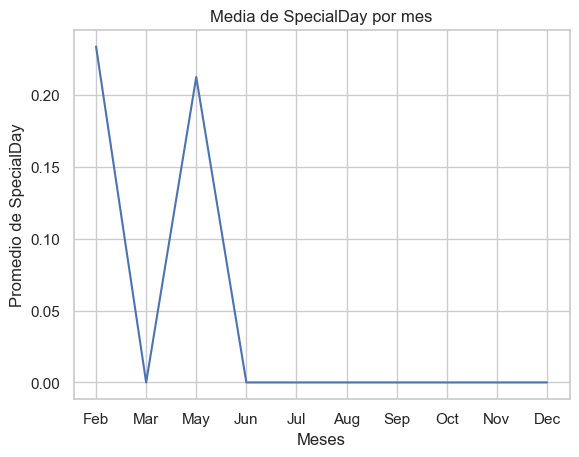

In [202]:
df_temp_8 = pd.DataFrame(df_data.groupby(by=["Month"], observed=False)["SpecialDay"].mean()).reset_index()
sns.lineplot(data=df_temp_8, x="Month", y="SpecialDay")
plt.ylabel("Promedio de SpecialDay")
plt.xlabel("Meses")
plt.title("Media de SpecialDay por mes")
plt.show()

Las gráficas aportan información interesante con respecto al negocio. Se entienden los picos de venta:
* En mayo a razón de la cantidad de promociones 
* En noviembre y diciembre por las compras de navidad

Esta información no es realmente concluyente como para afirmar la existencia de una correlación fuerte entre *Month* y *Revenue*. No es necesario incluir esta variable en el modelo de clasificación propuesto más adelante.

#### Weekend

In [203]:
df_temp_9 = pd.DataFrame(df_data.groupby(by=["Weekend", "Revenue"]).count()["ProductRelated"]).reset_index()
df_temp_9["Weekend"] = np.where(df_temp_9["Weekend"], "Fin de semana", "Lun-Vie")
df_temp_9["Revenue"] = np.where(df_temp_9["Revenue"], "Comprador", "No Comprador")
df_temp_9

,Weekend,Revenue,ProductRelated
0,Lun-Vie,No Comprador,8042
1,Lun-Vie,Comprador,1409
2,Fin de semana,No Comprador,2366
3,Fin de semana,Comprador,499


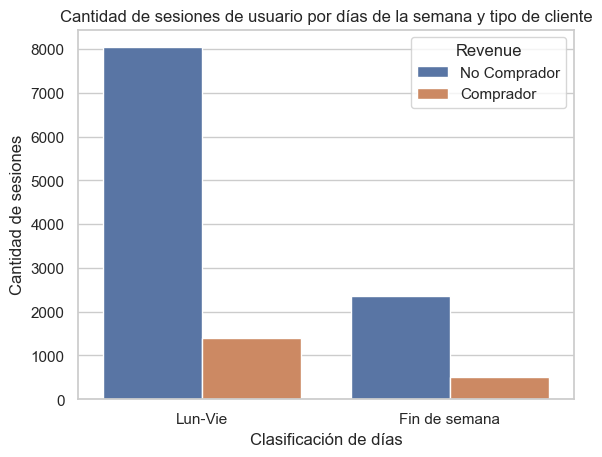

In [204]:
sns.barplot(data=df_temp_9, x="Weekend", y="ProductRelated", hue="Revenue")
plt.xlabel("Clasificación de días")
plt.ylabel("Cantidad de sesiones")
plt.title("Cantidad de sesiones de usuario por días de la semana y tipo de cliente")
plt.show()

El gráfico anterior no es concluyente para determinar una relación entre *Weekend* y *Revenue*, se propone analizar los porcentajes que representa cada clase por la clásificación de los días de la semana.

In [205]:
df_temp_10 = df_temp_9.pivot(index='Weekend', columns='Revenue', values='ProductRelated').reset_index()
df_temp_10.columns.name = None
df_temp_10["% Comprador"] = round((df_temp_10["Comprador"] /(df_temp_10["Comprador"] + df_temp_10["No Comprador"]))*100,2)
df_temp_10["% No Comprador"] = round((df_temp_10["No Comprador"] /(df_temp_10["Comprador"] + df_temp_10["No Comprador"]))*100,2)
df_temp_10

,Weekend,Comprador,No Comprador,% Comprador,% No Comprador
0,Fin de semana,499,2366,17.42,82.58
1,Lun-Vie,1409,8042,14.91,85.09


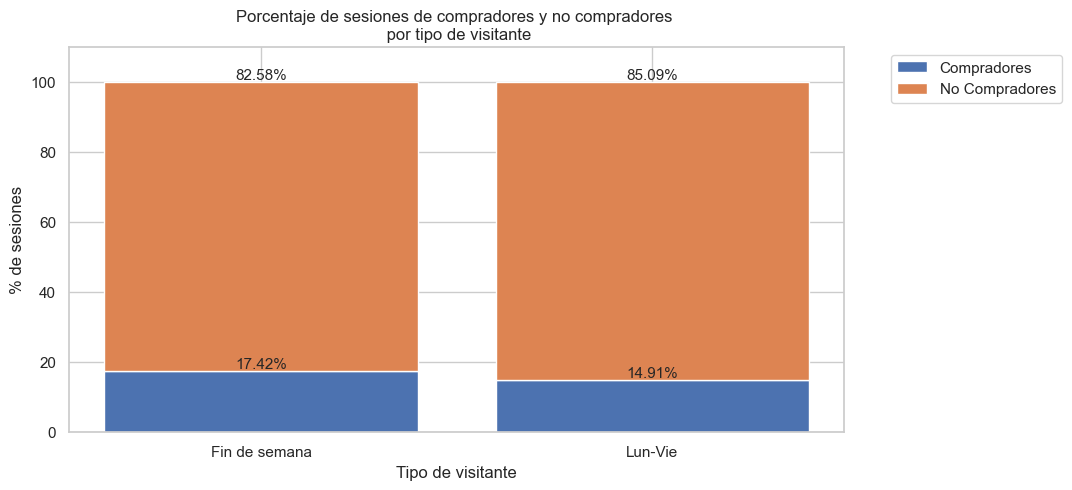

In [206]:
plt.figure(figsize=(10,5))

bars1 = plt.bar(df_temp_10["Weekend"], df_temp_10["% Comprador"], label="Compradores")
bars2 = plt.bar(df_temp_10["Weekend"], df_temp_10["% No Comprador"] , bottom=df_temp_10["% Comprador"], label="No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_10["% Comprador"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_10["% No Comprador"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Porcentaje de sesiones de compradores y no compradores \n por tipo de visitante")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Del gráfico se puede concluir que existe un porcentaje más alto de sesiones que realizan compras durante los fines de semana y en conjunto con el gráfico anterior se podría asumir que los clientes buscan y definen los productos a comprar de lunes a viernes, generando la compra entre sábado y domingo.

La relación no es necesariamente fuerte pero está presenta está variable se debe incluir en el modelo predictivo

Existen más varibles categóricas que podrían mostrar detalles más intrínsecos del negocio como el sistema operativo prefereido de los usuarios o el tipo de navegador entre otros, pero con el fin de cumplir las tareas solicitadas se plantea a continuación un modelo predictivo inicial del cual obtendremos las *Key Features*. 

De esta forma se puede validar el análisis exploratorio realizado hasta este punto y completarlo de ser el caso

### Histograma

In [228]:
df_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


c:\Python3.11\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 111'. Pick better value with 'binwidth'.


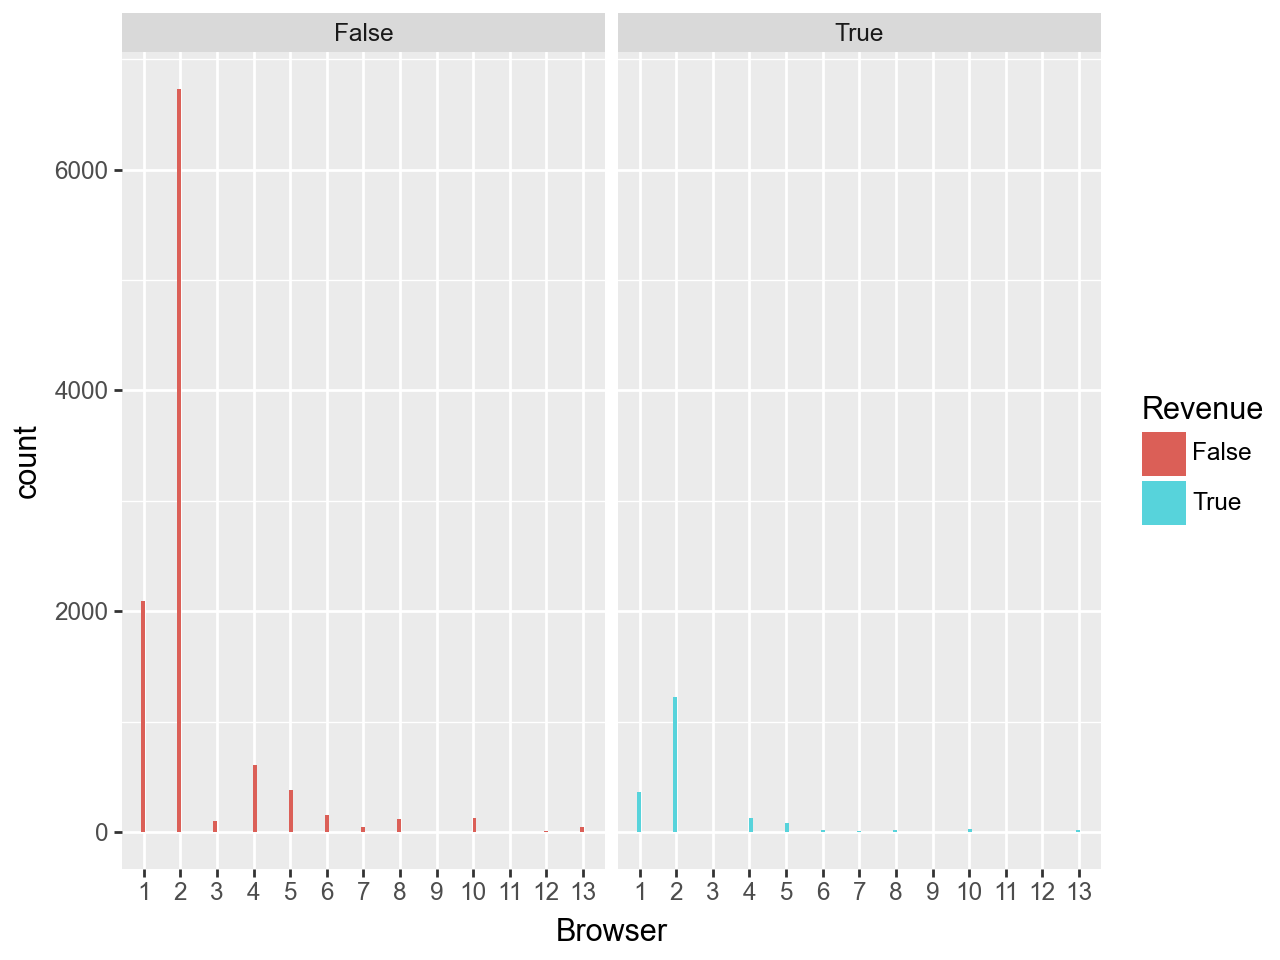

In [251]:
(
    ggplot(df_data) + 
    geom_histogram(mapping= aes("Browser", fill = "Revenue")) + 
    facet_wrap("~Revenue")
)

In [253]:
df_data["VisitorType"].unique()

['Returning_Visitor', 'New_Visitor', 'Other']
Categories (3, object): ['Returning_Visitor', 'New_Visitor', 'Other']

c:\Python3.11\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 81'. Pick better value with 'binwidth'.


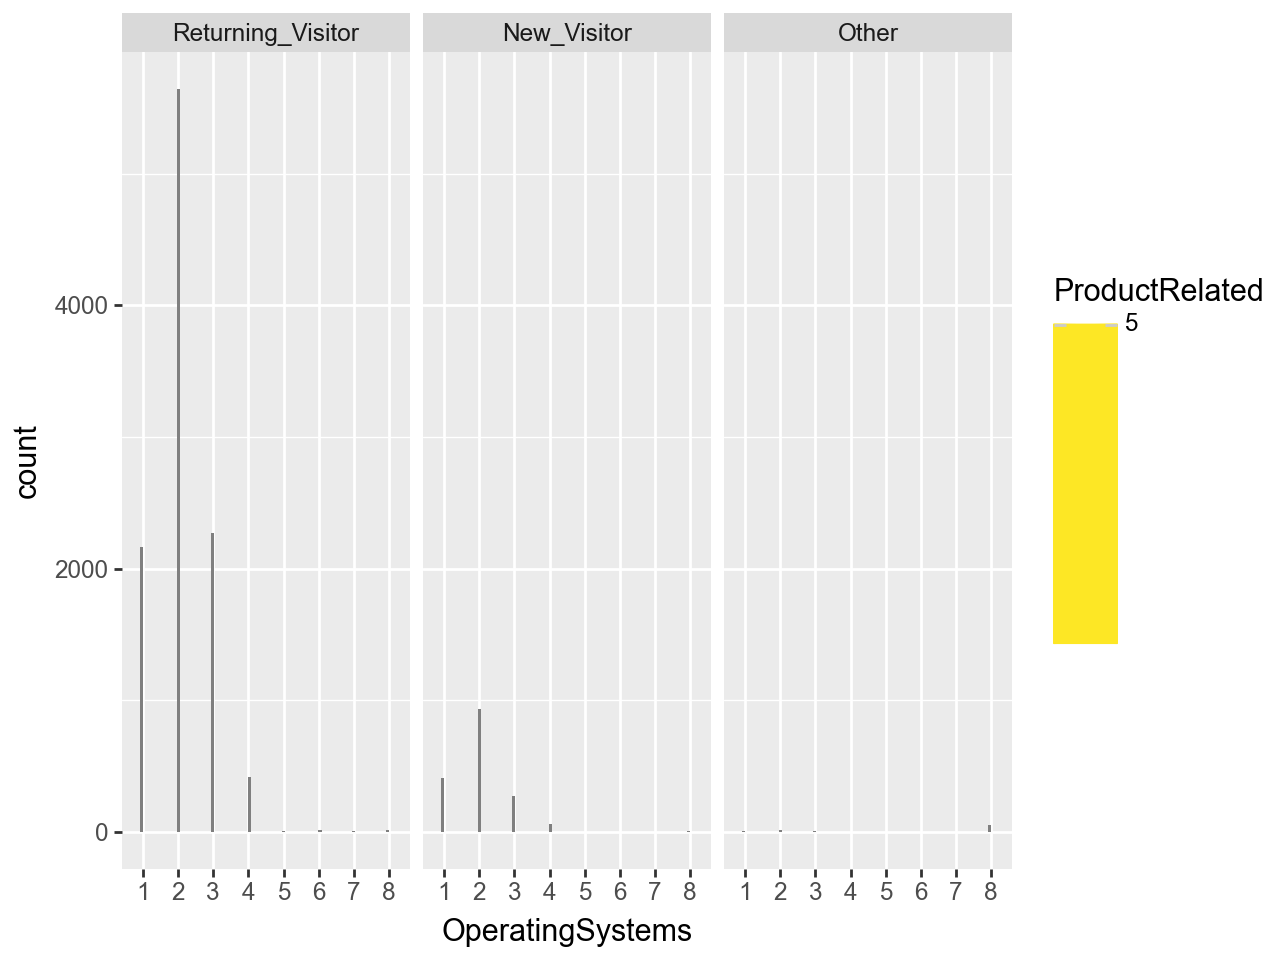

In [255]:
(
    ggplot(df_data) + 
    geom_histogram(mapping= aes("OperatingSystems", fill = "ProductRelated")) + 
    facet_wrap("~VisitorType")
)

# Modelo Predictivo

### Preparar los datasets

In [207]:
# !pip install scikit-learn
SEED = 1508
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump, load

Definir variables X, y para el modelo predictivo: 
* X: Todas las variables excepto *Month* y la variable objetivo *Revenue*
* y: Unicamente la varaible objetivo *Revenue* 

In [208]:
X = df_data.drop(columns=["Month", "Revenue"])
y = df_data["Revenue"]

* Separar en datasets de entramiento y prueba
* Asignar dummies
* Entrenar modelo

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=["OperatingSystems",
                                           "Browser",
                                           "Region",
                                           "TrafficType",
                                           "VisitorType"]
                        )

X_test = pd.get_dummies(X_test, columns=["OperatingSystems",
                                           "Browser",
                                           "Region",
                                           "TrafficType",
                                           "VisitorType"]
                        )

### Random Forest

Inicialmente se aplica un modelo predictivo random forest. Con el buscamos determinar cuales son las variables que tienen más impacto sobre la variable objetivo mediante la propiedad *Key Features* del modelo 

In [210]:
params = {"n_estimators" : [10, 50, 100, 200], "max_depth" : [5, 7, 9], "max_features": [10, "sqrt"]}
RFClassifier = RandomForestClassifier(random_state=SEED)
RFClassifier_grid = GridSearchCV(RFClassifier, params, cv=3, n_jobs=1)
RFClassifier_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1508),
             n_jobs=1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 'sqrt'],
                         'n_estimators': [10, 50, 100, 200]})

#### Métricas Random Forest sin GridSearchCV

Accuracy de data de entrenameinto 1.0
Accuracy de data de prueba 0.901
AUC ROC: 0.912
[[3023  100]
 [ 266  306]]


,False,True,accuracy
precision,0.919124,0.753695,0.900947
recall,0.967980,0.534965,0.900947
f1-score,0.942920,0.625767,0.900947
support,3123.000000,572.000000,0.900947


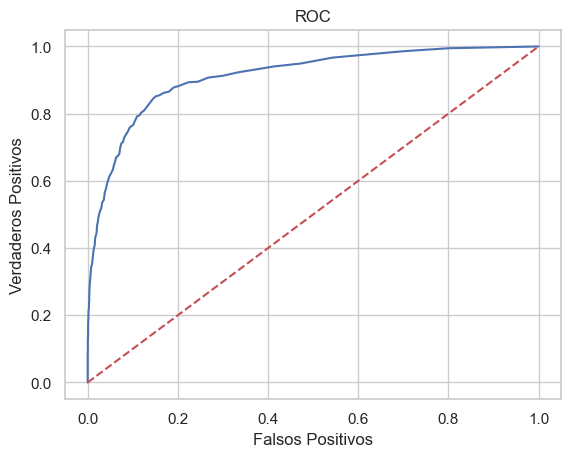

In [220]:
RFClassifier.fit(X_train, y_train)
y_pred_rf = RFClassifier.predict(X_test)
y_test_prob = RFClassifier.predict_proba(X_test)
score_train = RFClassifier.score(X_train, y_train) #score con data de entrenamiento ACCURACY!
score_test = RFClassifier.score(X_test, y_test) #score con data de prueba ACCURACY!
auc = roc_auc_score(y_test, y_test_prob[:,1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

matriz_confusion = confusion_matrix(y_test, y_pred_rf)
print(matriz_confusion)

conf_mtrx = confusion_matrix(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, output_dict=True)
df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

In [215]:
matriz_confusion

array([[3023,  100],
       [ 266,  306]], dtype=int64)

In [218]:
matriz_confusion[1][1]

306

#### Key Features

,Feature,Relevance
8,PageValues,3.440669e-01
5,ProductRelated_Duration,8.957987e-02
7,ExitRates,8.538107e-02
4,ProductRelated,7.468992e-02
1,Administrative_Duration,5.843922e-02
...,...,...
58,TrafficType_18,6.234930e-06
17,OperatingSystems_7,5.392805e-07
52,TrafficType_12,0.000000e+00
57,TrafficType_17,0.000000e+00


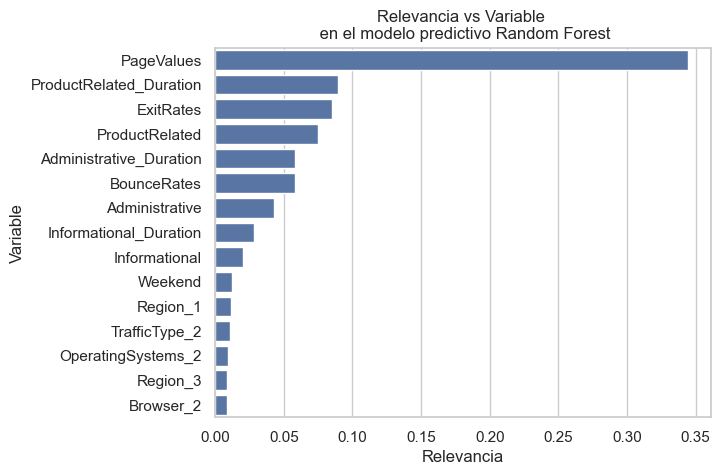

In [213]:
RFClassifier.fit(X_train, y_train)
relevances = RFClassifier.feature_importances_
df_features = pd.DataFrame({
    "Feature": X_train.columns,
    "Relevance": relevances
})
df_features = df_features.sort_values(by=["Relevance"], ascending=False)
display(df_features)

sns.barplot(data=df_features.iloc[:15], x="Relevance", y="Feature")
plt.ylabel("Variable")
plt.xlabel("Relevancia")
plt.title("Relevancia vs Variable \n en el modelo predictivo Random Forest")
plt.show()

Esta gráfica valida nuestro análisis exploratorio y da la razón al no haber analizado las variables categóricas ya que el impacto causado en *Revenue* es mínimo.

#### Predicción

Accuracy de data de entrenameinto 0.928
Accuracy de data de prueba 0.9
AUC ROC: 0.914


,False,True,accuracy
precision,0.913017,0.781163,0.900135
recall,0.974704,0.493007,0.900135
f1-score,0.942853,0.604502,0.900135
support,3123.000000,572.000000,0.900135


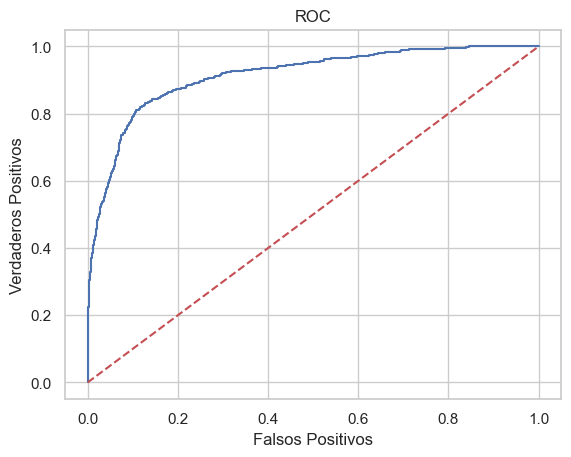

In [214]:
y_pred = RFClassifier_grid.predict(X_test)
y_test_prob = RFClassifier_grid.predict_proba(X_test)
score_train = RFClassifier_grid.score(X_train, y_train)
score_test = RFClassifier_grid.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

### Regresion Logística

In [215]:
from sklearn.linear_model import LogisticRegression

In [216]:
params = {
    'penalty': ['l1', 'l2'],            # Regularization penalty: l1 (Lasso) or l2 (Ridge)
    'C': [0.001, 0.01, 0.1, 1, 10],     # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],    # Algorithm to use in the optimization problem
    # 'max_iter': [500, 1000, 1500]         # Maximum number of iterations for optimization
}
LRClassifier = LogisticRegression(random_state=SEED)
LRClassifier_grid = GridSearchCV(LRClassifier, params, cv=3, n_jobs=1)
LRClassifier_grid.fit(X_train, y_train)

c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=1508), n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

#### Predicción

Accuracy de data de entrenameinto 0.886
Accuracy de data de prueba 0.889
AUC ROC: 0.856


,False,True,accuracy
precision,0.898824,0.772881,0.888769
recall,0.978546,0.398601,0.888769
f1-score,0.936992,0.525952,0.888769
support,3123.000000,572.000000,0.888769


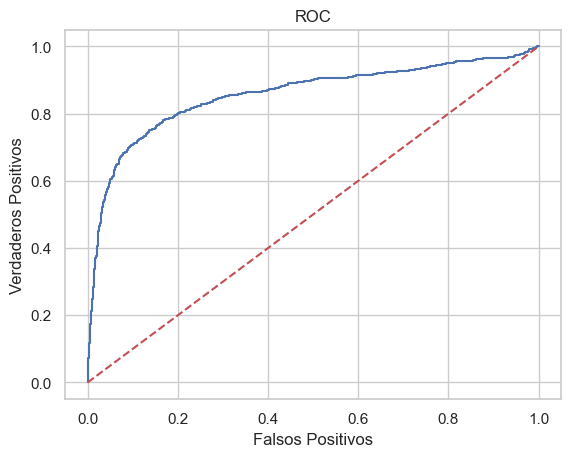

In [217]:
y_pred = LRClassifier_grid.predict(X_test)
y_test_prob = LRClassifier_grid.predict_proba(X_test)
score_train = LRClassifier_grid.score(X_train, y_train)
score_test = LRClassifier_grid.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

### MLP

In [149]:
from sklearn.neural_network import MLPClassifier

In [150]:
# neural_model = MLPClassifier(random_state=SEED, 
#                              max_iter=50,
#                              alpha=0.1,
#                              hidden_layer_sizes=20,
#                              solver="lbfgs")
neural_model = MLPClassifier(random_state=SEED)
neural_model.fit(X_train, y_train)

MLPClassifier(random_state=1508)

Accuracy de data de entrenameinto 0.877
Accuracy de data de prueba 0.877
AUC ROC: 0.714


,False,True,accuracy
precision,0.879443,0.831461,0.877131
recall,0.990394,0.258741,0.877131
f1-score,0.931627,0.394667,0.877131
support,3123.000000,572.000000,0.877131


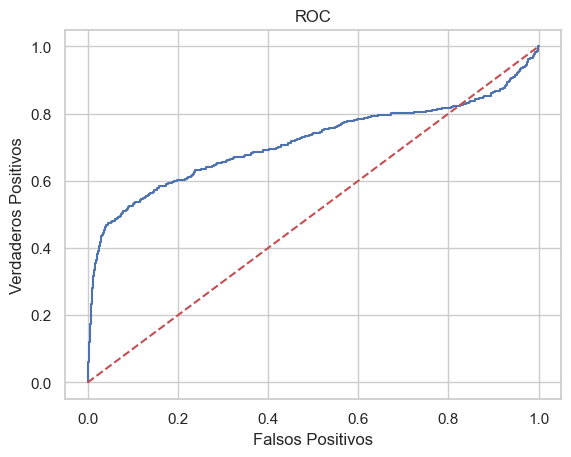

In [151]:
y_pred = neural_model.predict(X_test)

y_test_prob = neural_model.predict_proba(X_test)
score_train = neural_model.score(X_train, y_train)
score_test = neural_model.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()


### MLP con optimización de Hiperparámetros

In [152]:
params = {
    'solver': ['lbfgs'], 
    'max_iter': [100,200,300], # Iteraciones máximas en cada red
    'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
    'hidden_layer_sizes':[30,50,70], # Número de neuronas en cada capa
    'random_state':[0]
}
neural_model_grid = GridSearchCV(neural_model, param_grid=params, cv=3, scoring="roc_auc", n_jobs=-1, verbose=10)
neural_model_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=1508), n_jobs=-1,
             param_grid={'alpha': array([0.1 , 0.01]),
                         'hidden_layer_sizes': [30, 50, 70],
                         'max_iter': [100, 200, 300], 'random_state': [0],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=10)

In [153]:
print(neural_model_grid.best_params_, f"ROC AUC: {round(neural_model_grid.best_score_,3)}")

{'alpha': 0.1, 'hidden_layer_sizes': 70, 'max_iter': 300, 'random_state': 0, 'solver': 'lbfgs'} ROC AUC: 0.86


In [154]:
best_neural_model = MLPClassifier(**neural_model_grid.best_params_)
best_neural_model.fit(X_train, y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=70, max_iter=300, random_state=0,
              solver='lbfgs')

Accuracy de data de entrenameinto 0.882
Accuracy de data de prueba 0.887
AUC ROC: 0.823


,False,True,accuracy
precision,0.899055,0.749186,0.886604
recall,0.975344,0.402098,0.886604
f1-score,0.935647,0.523322,0.886604
support,3123.000000,572.000000,0.886604


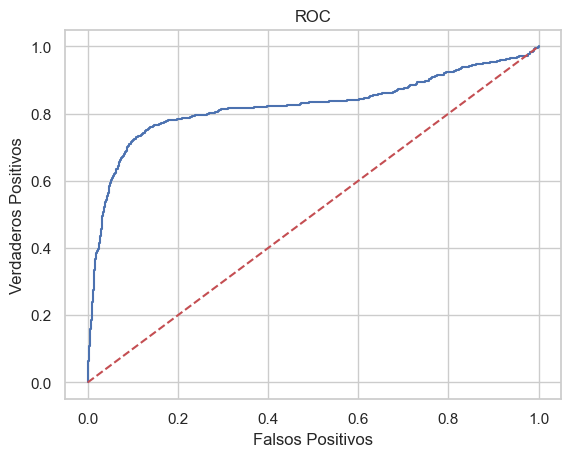

In [155]:
y_pred = best_neural_model.predict(X_test)

y_test_prob = best_neural_model.predict_proba(X_test)
score_train = best_neural_model.score(X_train, y_train)
score_test = best_neural_model.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()